In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

## Dataset

In [2]:
df = pd.read_csv('datasets/netflix_stock_price_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
5728,2002-05-23,1.16,1.24,1.15,1.2,1.2,"104,790,000"
5727,2002-05-24,1.21,1.23,1.2,1.21,1.21,"11,104,800"
5726,2002-05-28,1.21,1.23,1.16,1.16,1.16,"6,609,400"
5725,2002-05-29,1.16,1.16,1.09,1.1,1.1,"6,757,800"
5724,2002-05-30,1.11,1.11,1.07,1.07,1.07,"10,154,200"


### Cleansing Data

In [3]:
# Drop rows with null values
df = df.dropna()

In [4]:
# Remove commas from numeric columns
numeric_columns = [col for col in df.columns if col not in ['Date']]
for col in numeric_columns:
    if df[col].dtype == 'object':  # Only process string columns
        df[col] = df[col].str.replace(',', '').astype(float)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
5728,2002-05-23,1.16,1.24,1.15,1.20,1.20,104790000.0
5727,2002-05-24,1.21,1.23,1.20,1.21,1.21,11104800.0
5726,2002-05-28,1.21,1.23,1.16,1.16,1.16,6609400.0
5725,2002-05-29,1.16,1.16,1.09,1.10,1.10,6757800.0
5724,2002-05-30,1.11,1.11,1.07,1.07,1.07,10154200.0


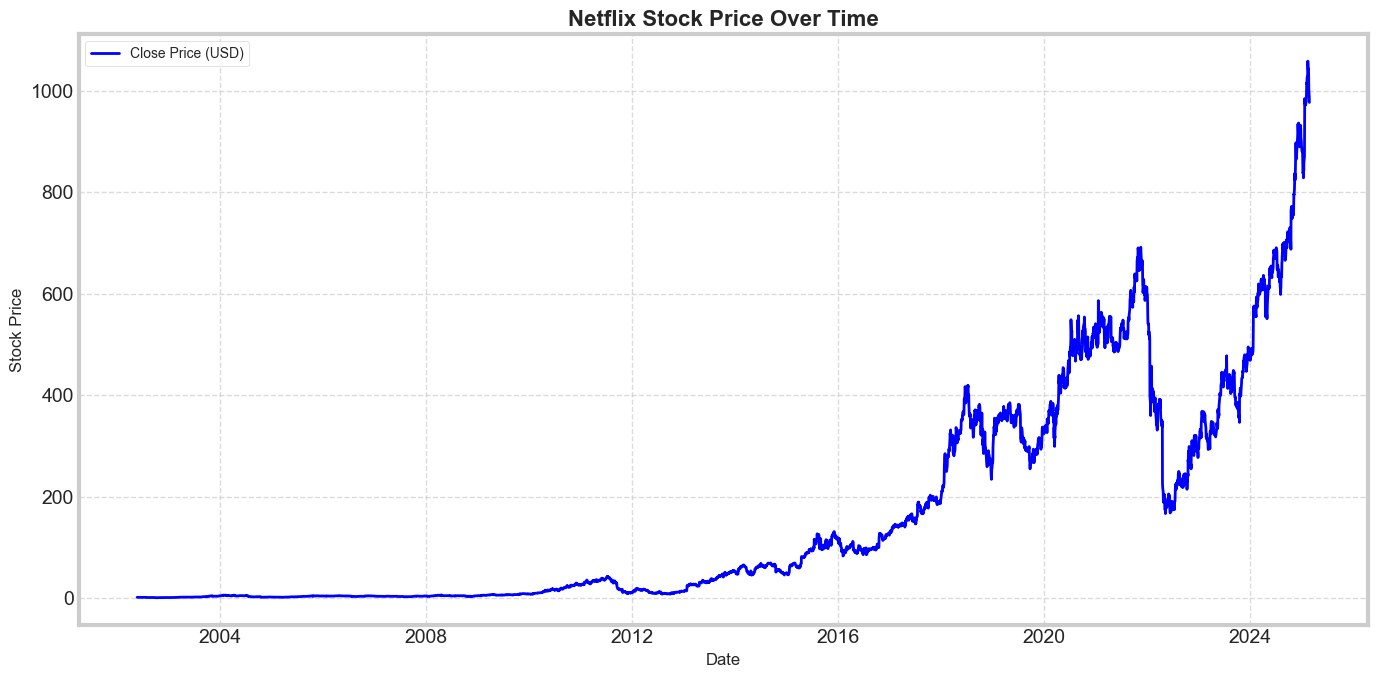

In [5]:
# Plotting the stock price over time
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price (USD)', color='blue', linewidth=2)

# Enhance the title and labels
plt.title('Netflix Stock Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)

# Customize the legend
plt.legend(loc='upper left', fontsize=10)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

## Add features for improved model

### Moving Average (MA)

ค่าเฉลี่ยเคลื่อนที่ ช่วยดูแนวโน้มราคา

In [6]:
df["MA5"] = df["Close"].rolling(window=5).mean()
df["MA10"] = df["Close"].rolling(window=10).mean()
df["MA50"] = df["Close"].rolling(window=50).mean()

### Relative Strength Index (RSI)

วัดว่าหุ้นอยู่ในโซน Overbought (>70) หรือ Oversold (<30)

In [7]:
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df["RSI14"] = calculate_rsi(df["Close"])

### MACD (Moving Average Convergence Divergence)

วัดโมเมนตัมของราคา

In [8]:
df["EMA12"] = df["Close"].ewm(span=12, adjust=False).mean()
df["EMA26"] = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = df["EMA12"] - df["EMA26"]
df["Signal_Line"] = df["MACD"].ewm(span=9, adjust=False).mean()

### Lag Features (ราคาย้อนหลัง)

ราคาปิดย้อนหลัง 1, 2, 3 วัน

In [9]:
df["Close_Lag1"] = df["Close"].shift(1)
df["Close_Lag2"] = df["Close"].shift(2)
df["Close_Lag3"] = df["Close"].shift(3)

### Volatility (Rolling Standard Deviation)

ความผันผวนของราคาช่วง 10 วัน

In [10]:
df["Volatility"] = df["Close"].rolling(window=10).std()

### Rate of Change (ROC)

อัตราการเปลี่ยนแปลงของราคาในช่วง 10 วัน

In [11]:
df["ROC"] = df["Close"].pct_change(periods=10) * 100

In [12]:
# ลบค่าที่เป็น NaN (เกิดจาก rolling window)
df = df.dropna()

df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,MA5,MA10,MA50,RSI14,EMA12,EMA26,MACD,Signal_Line,Close_Lag1,Close_Lag2,Close_Lag3,Volatility,ROC
4,2025-02-19,1035.18,1045.00,1024.51,1043.33,1043.33,2600000.0,1041.756,1028.518,936.8868,69.988960,1019.740676,983.856881,35.883795,33.637265,1035.85,1058.60,1043.69,16.696461,4.870988
3,2025-02-20,1042.00,1045.00,1015.59,1024.54,1024.54,3111800.0,1041.202,1029.861,939.0202,64.498078,1020.479033,986.870445,33.608588,33.631530,1043.33,1035.85,1058.60,15.647846,1.328243
2,2025-02-21,1029.42,1032.38,999.39,1003.15,1003.15,3738700.0,1033.094,1028.608,940.3884,56.773962,1017.813028,988.076338,29.736690,32.852562,1024.54,1043.33,1035.85,17.321702,-1.233656
1,2025-02-24,1008.00,1015.17,984.48,988.47,988.47,4426200.0,1019.068,1026.062,941.8840,52.298712,1013.298716,988.105498,25.193218,31.320693,1003.15,1024.54,1043.33,21.163823,-2.511021
0,2025-02-25,989.40,994.40,955.00,977.24,977.24,4733000.0,1007.346,1021.026,943.1618,45.648847,1007.751221,987.300646,20.450575,29.146669,988.47,1003.15,1024.54,26.159289,-4.900740


## Netflix Stock Price Prediction

### Gradient Boosting Regression

In [ ]:
class GradientBoostingRegressor:
    def __init__(self, n_trees=100, learning_rate=0.1, max_depth=4):
        self.n_trees = n_trees
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.H = None
        
    def _negative_gradient(self, y, H):
        return y - H
    
    def _build_tree(self, X, y, depth=0):
        # Initialize sample indices if not provided
        if sample_indices is None:
            sample_indices = np.arange(X.shape[0])
        
        # Create feature subsetting (random column sampling)
        if feature_subset is None:
            n_features = X.shape[1]
            # Sample sqrt(n_features) as in RandomForest
            feature_subset = np.random.choice(n_features, 
                                            max(1, int(np.sqrt(n_features))), 
                                            replace=False)
        
        # Early stopping conditions
        if depth >= self.max_depth or len(set(y[sample_indices])) == 1 or len(sample_indices) < 10:
            return np.mean(y[sample_indices])
        
        best_feature, best_threshold, best_mse = None, None, float('inf')
        best_split = None
        
        for feature_idx in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = X[:, feature_idx] > threshold
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                y_left, y_right = y[left_mask], y[right_mask]
                mse = (np.mean((y_left - np.mean(y_left)) ** 2) +
                       np.mean((y_right - np.mean(y_right)) ** 2))
                
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature_idx
                    best_threshold = threshold
                    best_split = (left_mask, right_mask)
                    
        if best_split is None:
            return np.mean(y)
        
        left_subtree = self._build_tree(X[best_split[0]], y[best_split[0]], depth + 1)
        right_subtree = self._build_tree(X[best_split[1]], y[best_split[1]], depth + 1)
        
        return (best_feature, best_threshold, left_subtree, right_subtree)
    
    def _predict_tree(self, tree, x):
        if isinstance(tree, (int, float)):
            return tree
        
        feature, threshold, left_subtree, right_subtree = tree
        if x[feature] <= threshold:
            return self._predict_tree(left_subtree, x)
        else:
            return self._predict_tree(right_subtree, x)
        
    def _predict_tree_batch(self, tree, X):
        if isinstance(tree, (int, float)):
            return np.full(X.shape[0], tree)
        
        feature, threshold, left_subtree, right_subtree = tree
        left_mask = X[:, feature] <= threshold
        
        # Prepare result array
        predictions = np.empty(X.shape[0])
        
        # Recurse on left and right sides if there are samples
        if np.any(left_mask):
            predictions[left_mask] = self._predict_tree_batch(left_subtree, X[left_mask])
        if np.any(~left_mask):
            predictions[~left_mask] = self._predict_tree_batch(right_subtree, X[~left_mask])
        
        return predictions
        
    def fit(self, X, y):
        # Initialize H as the mean of y
        mean_y = np.mean(y)
        self.H = np.full(y.shape, mean_y)
        
        with tqdm(total=self.n_trees, desc="Training Progress", unit="tree") as pbar:
            for _ in range(self.n_trees):
                # Calculate the negative gradient
                residuals = self._negative_gradient(y, self.H)
                
                # Build a tree to approximate the negative gradient
                tree = self._build_tree(X, residuals)
                self.trees.append(tree)
                
                # Update H using batch prediction
                self.H += self.learning_rate * self._predict_tree_batch(tree, X)
                
                pbar.update(1)
                
    def predict(self, X):
        predictions = np.full(X.shape[0], np.mean(self.H))
        for tree in self.trees:
            for i in range(len(X)):
                predictions[i] += self.learning_rate * self._predict_tree(tree, X[i])
        return predictions

### Training a Model

In [14]:
# Features and Targets
X = df[[col for col in df.columns if col not in ['Close']]].values
y = df['Close'].values

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (4542, 19)
X_test shape: (1136, 19)


In [15]:
# Train the model
gbrt = GradientBoostingRegressor(n_trees=100, learning_rate=0.1, max_depth=4)
gbrt.fit(X_train, y_train)

Training Progress:   0%|          | 0/100 [00:15<?, ?tree/s]


KeyboardInterrupt: 

In [ ]:
# Make predictions on the testing set
y_pred = gbrt.predict(X_test)

# Calculate the mean squared error
mse = np.mean((y_pred - y_test) ** 2)
print(f"Mean squared error: {mse:.4f}")

Mean squared error: 12984.3160


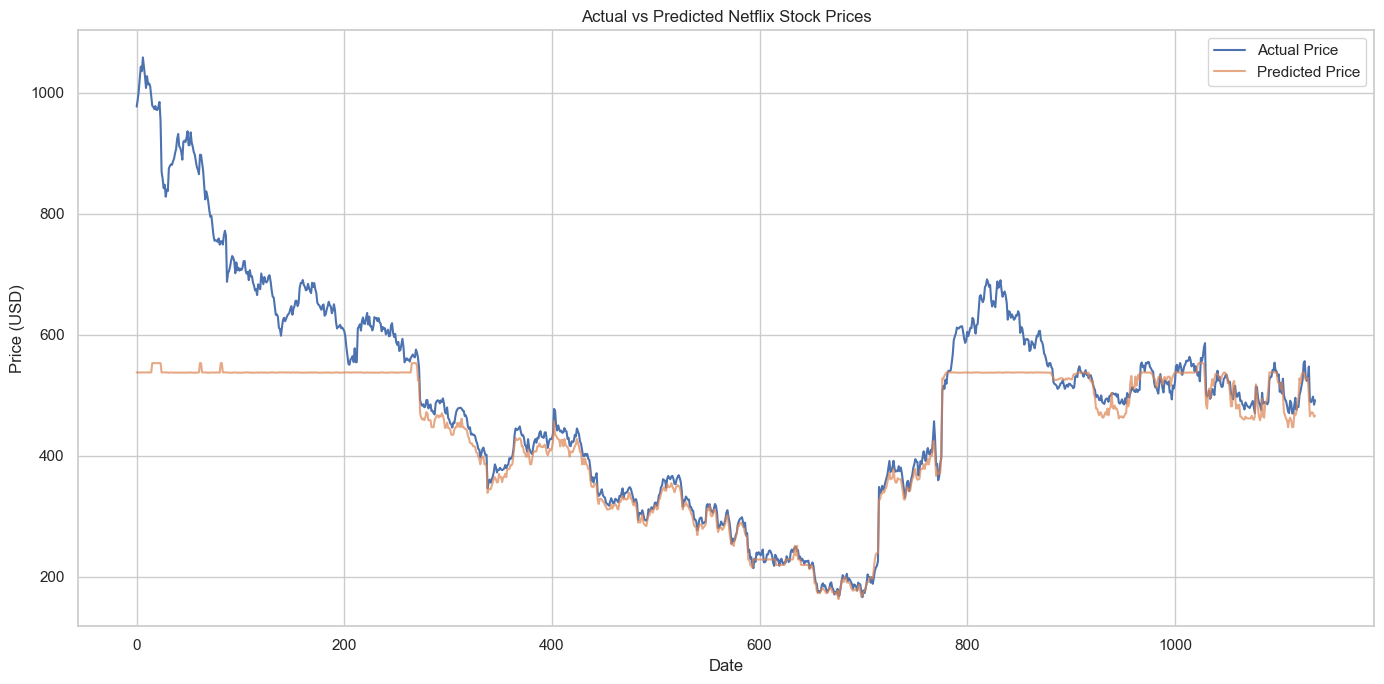

In [ ]:
# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.title('Actual vs Predicted Netflix Stock Prices')
plt.plot(df.index[-len(y_test):], y_test, label='Actual Price')
plt.plot(df.index[-len(y_test):], y_pred, label='Predicted Price', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Predicts the price of netflix stock